# Импорты

In [ ]:
for model in models:
    np.save('./swin-roc-scores/' + model_names[model])
print('done')

In [ ]:
from transformers import AutoImageProcessor, SwinForImageClassification
from transformers import TrainingArguments, Trainer
from transformers import AutoFeatureExtractor
from transformers import pipeline
import torch
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 20
print(f"device: {device}")

In [ ]:
from datasets import load_dataset
# dataset = load_dataset("mvkvc/artifact-100k") # subset of ArtiFact labled with "ai" and "real" tags
dataset = load_dataset("imagefolder", data_dir="../datasets/artifacts")
dataset = dataset.with_format(type="torch", device=device)

model_name= 'microsoft/swin-base-patch4-window7-224'
feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)

def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([x.convert('RGB') for x in example_batch['image']], return_tensors='pt')
    inputs['label'] = example_batch['label']
    return inputs

prepared_ds = dataset.with_transform(transform)

In [ ]:

def get_label(ind):
    return dataset["train"].features['label'].names[ind]

def show_img(ind):
    l = len(dataset["train"])
    while ind < 0:
        ind += l
    data = dataset["train"][ind]
    plt.imshow(data["image"].cpu().numpy())
    plt.title(f"Image #{ind}, class: {get_label(data['label'])}")

show_img(-15)

In [ ]:
models = [f"test_trainer{i}" for i in range(4,11)]
print(models)

In [ ]:
from PIL import Image
from torchvision.transforms.functional import to_pil_image
from sklearn import metrics
import numpy as np

roc_scores = {}
auc_scores = {}

for model in models:
    print(f"Модель {model}: Загрузка...", end=" ")
    pipe = pipeline("image-classification", model=model, device=device)

    print("Метрики...", end=" ")
    # Рассчет метрик
    y_score = []
    y_target = []
    for data in dataset["test"]:
        inp, targ = data["image"], data["label"]
        
        targ = float(targ)
        
        inp = inp.permute(2, 1, 0)
        img = to_pil_image(inp)
        out = pipe(img)[1]["score"]
        y_target.append(targ)
        y_score.append(out)
    fpr, tpr, thresholds = metrics.roc_curve(y_target, y_score)
    auc = metrics.roc_auc_score(y_target, y_score)
    roc_scores[model] = [fpr,tpr]
    auc_scores[model] = auc

    print(f"Сохранение резульата...", end=" ")
    # Сохранение метрик
    with open(f"./swin_roc/{model}.npy", "wb") as f:
        np.save(f,np.row_stack((fpr,tpr)))
    print("Готово.")

In [ ]:
# Model name mapping
model_names = {
    "test_trainer4" : "SWIN (Base Artifact100k)",
    "test_trainer5" : "SWIN (Large Artifact100k)",
    "test_trainer6" : "SWIN (Base Artifacts)",
    "test_trainer7" : "SWIN (Large Artifacts)",
    "test_trainer8" : "SWIN (Base Artifact100k+Artifacts)",
    "test_trainer9" : "SWIN (Large Artifact100k+Artifacts)",
    "test_trainer10" : "SWIN (Base Artifacts+Artifact100k)"
}

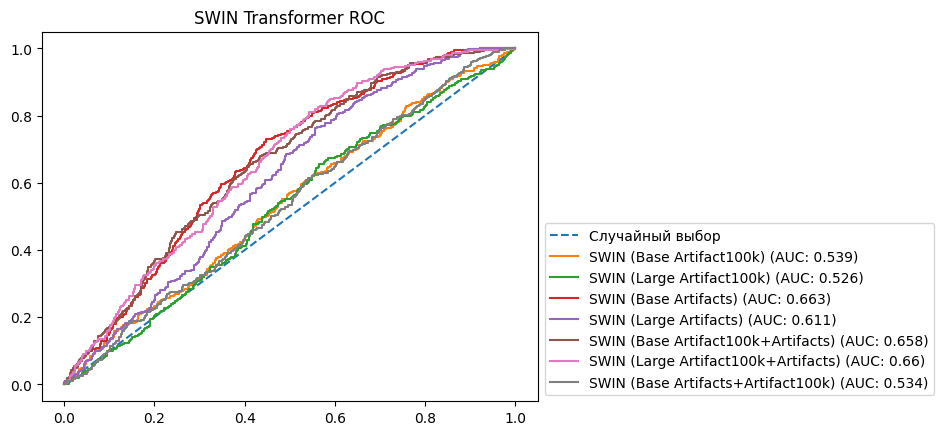

In [106]:
plt.title("SWIN Transformer ROC")
plt.plot([0,1],[0,1], label="Случайный выбор", linestyle="dashed")
for model in models:
    plt.plot(roc_scores[model][0],roc_scores[model][1], label=model_names[model] + f" (AUC: {round(auc_scores[model], 3)})")
    np.save('./swin-roc-scores/' + model_names[model])
plt.legend(bbox_to_anchor=(1, 0.5))
plt.show()